In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

In [110]:
def RBF(x1,x2,*,length_scale=1.0):
    return np.exp(-0.5/length_scale**2 * (x1-x2)**2)

def dRBF(x1,x2,*,length_scale=1.0):
    return -(x1-x2)/length_scale**2 * RBF(x1,x2,length_scale=length_scale)

def ddRBF(x1,x2,*,length_scale=1.0):
    return (1 - (x1-x2)**2 / length_scale**2) / length_scale**2 * RBF(x1,x2,length_scale=length_scale)

def covMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = RBF(xs,ys,length_scale=length_scale)
    
    return mat

def dcovMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = dRBF(xs,ys,length_scale=length_scale)
    
    return mat

def ddcovMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = ddRBF(xs,ys,length_scale=length_scale)
    
    return mat

def sigmaMatrix(sigma_sq,*,size=0):
    if np.isscalar(sigma_sq):
        return np.eye(size) / sigma_sq
    
    return np.diag(1 / sigma_sq)

In [111]:
def func(x,noise=0.0):
    return np.sin(x) + noise*np.random.randn(*x.shape)

def grad_func(x,noise=0.0):
    return np.cos(x) + noise*np.random.randn(*x.shape)

## Sparse GPR

In [112]:
# bounds = np.array([0.0, np.pi])

# noise = 0.1

# length_scale = 1.0

# num_reference_points = 10
# referencegrid = np.linspace(*bounds,num_reference_points)

# num_datapoints = 15
# datagrid = np.random.uniform(*bounds,num_datapoints)
# data_values = func(datagrid,noise)
# derivative_values = grad_func(datagrid,noise)

# num_gridpoints = 101
# grid = np.linspace(*bounds,num_gridpoints)

In [113]:
# K_MM = covMatrix(reference_points=referencegrid,data_points=referencegrid,length_scale=length_scale)
# K_MN = covMatrix(reference_points=referencegrid,data_points=datagrid,length_scale=length_scale)
# DK_MN = dcovMatrix(reference_points=referencegrid,data_points=datagrid,length_scale=length_scale)
# LK = np.concatenate((K_MN,DK_MN),axis=1)

# S_big = sigmaMatrix(noise**2,size=2*num_datapoints)
# S_small = sigmaMatrix(noise**2,size=num_datapoints)
# values = np.concatenate((data_values,derivative_values))

In [114]:
# matrix = K_MM + LK@S_big@LK.T
# vector = LK@S_big@values
# # vector = LK@values
# coeff_mix = solve(matrix,vector)

# matrix = K_MM + DK_MN@S_small@DK_MN.T
# vector = DK_MN@S_small@derivative_values
# # vector = DK_MN@derivative_values
# coeff_der = solve(matrix,vector)

# matrix = K_MM + K_MN@S_small@K_MN.T
# vector = K_MN@S_small@data_values
# # vector = K_MN@data_values
# coeff_val = solve(matrix,vector)

# pred_mix = [coeff_mix@RBF(x,referencegrid) for x in grid]
# pred_der = [coeff_der@RBF(x,referencegrid) for x in grid]
# pred_val = [coeff_val@RBF(x,referencegrid) for x in grid]

In [115]:
# f, ax = plt.subplots(1,3,figsize=(15, 5))
# for i in range(3):
#     ax[i].plot(grid,func(grid),"k--",label="true")
#     ax[i].vlines(referencegrid,0,1,ls="--",colors="grey",lw=0.5,transform=ax[i].get_xaxis_transform(),label="ref grid")
#     ax[i].grid()
#     ax[i].scatter(datagrid,data_values,c="r")
# ax[0].plot(grid,pred_mix,c="b",label="mixed")
# ax[1].plot(grid,pred_der,c="b",label="derivatives")
# ax[2].plot(grid,pred_val,c="b",label="func_evals")
# ax[0].set_title("derivatives + function evals")
# ax[1].set_title("derivatives")
# ax[2].set_title("function evals")

## Full GPR for 1 function value and N derivative values

In [116]:
# bounds = np.array([0.0, np.pi])

# noise = 0.05

# length_scale = 1.0

# num_derivpoints = 5
# derivgrid = np.linspace(*bounds,num_derivpoints)
# derivative_values = grad_func(derivgrid,noise)
# num_datapoints = 3
# datagrid = np.linspace(*bounds,num_datapoints)
# data_values = func(datagrid,noise)

# fullgrid = np.zeros(num_datapoints+num_derivpoints)
# full_values = np.zeros(num_datapoints+num_derivpoints)
# fullgrid[:num_datapoints] = datagrid
# fullgrid[num_datapoints:] = derivgrid
# full_values[:num_datapoints] = data_values
# full_values[num_datapoints:] = derivative_values

# num_gridpoints = 101
# grid = np.linspace(*bounds,num_gridpoints)

In [117]:
# KV = covMatrix(fullgrid[:num_datapoints],fullgrid[:num_datapoints],length_scale=length_scale)
# KD = ddcovMatrix(fullgrid[num_datapoints:],fullgrid[num_datapoints:],length_scale=length_scale)
# KM = dcovMatrix(fullgrid[:num_datapoints],fullgrid[num_datapoints:],length_scale=length_scale)

# K_NN = np.zeros((num_datapoints+num_derivpoints,)*2)
# K_NN[:num_datapoints,:num_datapoints] = KV
# K_NN[num_datapoints:,num_datapoints:] = KD
# K_NN[:num_datapoints,num_datapoints:] = KM
# K_NN[num_datapoints:,:num_datapoints] = KM.T

In [118]:
# invert_mat = K_NN + np.eye(num_datapoints+num_derivpoints)*noise**2
# pred_coeff = solve(invert_mat,full_values)

# prediction = np.zeros_like(grid)
# vars = np.zeros_like(grid)

# k_vec = np.zeros(num_datapoints+num_derivpoints)

# for i,x in enumerate(grid):
#     k_vec[:num_datapoints] = RBF(datagrid,x)
#     k_vec[num_datapoints:] = dRBF(derivgrid,x)

#     prediction[i] = pred_coeff@k_vec
#     vars[i] = RBF(x,x) + noise**2 - k_vec@solve(invert_mat,k_vec)

derivgrid must be in first position since the measured values are those from derivatives and dRBF was defined as the derivative w.r. to the first argument!!!

In [119]:
# def slope(x,xref,yref,grad):
#     return grad*(x-xref) + yref

In [120]:
# stds = np.sqrt(vars)

# plt.plot(grid,prediction,"b",label="prediction")
# plt.fill_between(grid,prediction-2*stds,prediction+2*stds,alpha=0.5,color="b",label="95% conf")
# plt.scatter(datagrid,data_values,color="r")
# for xref in derivgrid:
#     slope_range = np.linspace(xref-0.2,xref+0.2,5)
#     plt.plot(slope_range,slope(slope_range,xref,func(xref),grad_func(xref)),"r")
#     plt.scatter(xref,func(xref),s=80,facecolors="none",edgecolors="r")
# plt.plot(grid,func(grid),"r--",label="true func")
# plt.grid()
# plt.legend()

## Sparse GPR with class

### class

In [121]:
class sparseGPR:
    def __init__(self,kernel,num_datapoints=None,num_derivpoints=None,X_ref=None,noise=1e-5) -> None:
        self.kernel = kernel

        self.num_datapoints = num_datapoints
        self.num_derivpoints = num_derivpoints

        # X_ref must be given for now!!!!!
        if X_ref is None:
            raise ValueError("X_ref can't be None!")
        self.X_ref = X_ref
        self.num_referencepoints = len(X_ref)
        self.K_MM = self._create_covMatrix(self.X_ref,self.X_ref,self.kernel.eval)

        self.noise = noise
        self.regress_coeff = None
        self.fit_vector = None
        self.fit_matrix = None

    def fit(self,X_data,Y_data) -> None:
        '''
            X_data ... (datapoint_1, ..., datapoint_N1, derivpoint_1, ..., derivpoint_N2)
            Y_data ... same shape as X_data
            
            for now X_ref must be given!!!!
        '''
        X_func = X_data[:self.num_datapoints]
        X_deriv = X_data[self.num_datapoints:]
        
        K_func = self._create_covMatrix(self.X_ref,X_func,self.kernel.eval)
        K_deriv = self._create_covMatrix(self.X_ref,X_deriv,self.kernel.dx2)
        K_MN = np.concatenate((K_func,K_deriv),axis=0)

        print(K_func.shape,K_deriv.shape,K_MN.shape,sep="\n\n")

        self.fit_matrix = self.K_MM + K_MN.T@K_MN / self.noise**2
        self.fit_vector = K_MN.T@Y_data / self.noise**2

    def predict(self,X, return_std=False):
        '''
            for now X_ref must be given in self.fit!!!
        '''
        if self.fit_matrix is None or self.fit_vector is None:
            raise ValueError("GPR not correctly fitted!")
        if self.X_ref is None:
            raise ValueError("X_ref can't be None!")
        
        ref_vectors = self._create_covMatrix(self.X_ref,X,self.kernel.eval).T
        X_cov = self.kernel.eval(X,X)

        means = ref_vectors.T@solve(self.fit_matrix,self.fit_vector)

        if return_std:
            stds = np.sqrt(X_cov + self.noise**2 - ref_vectors.T@solve(self.K_MM + self.fit_matrix,ref_vectors))
            return means, stds
        
        return means
    
    def _create_covMatrix(self, reference_points, data_points, kernel):
        xs,ys = np.meshgrid(reference_points,data_points,sparse=True)
        mat = kernel(xs,ys)
        
        return mat

class RBF:
    def __init__(self,length_scale=1.0,coeff=1.0):
        self.length_scale = length_scale
        self.coeff = coeff

    def eval(self,x1,x2):
        return self.coeff*np.exp(-0.5/self.length_scale**2 * (x1-x2)**2)
    
    def dx2(self,x1,x2):
        return (x1-x2)/self.length_scale**2 * self.eval(x1,x2)
    
    def ddx1x2(self,x1,x2):
        return (1 - (x1-x2)**2 / self.length_scale**2) / self.length_scale**2 * self.eval(x1,x2)

### calc

In [122]:
# import gaussian_process_regression as gpr

In [123]:
bounds = np.array([0.0, np.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 15
datagrid = np.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
derivative_values = grad_func(datagrid,noise)

X_data = np.concatenate((datagrid,datagrid))
Y_data = np.concatenate((data_values,derivative_values))

referencegrid = datagrid

num_gridpoints = 101
grid = np.linspace(*bounds,num_gridpoints)

kernel = RBF()
model = sparseGPR(kernel,num_datapoints,num_datapoints,referencegrid,noise)

In [124]:
print(X_data.shape)
print(Y_data.shape)

(30,)
(30,)


In [125]:
model.fit(X_data,Y_data)

(15, 15)

(15, 15)

(30, 15)


In [126]:
# print(model.fit_matrix.shape)
(means, stds) = model.predict(grid,True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_8320\843409950.py:51: LinAlgWarning: Ill-conditioned matrix (rcond=2.68163e-17): result may not be accurate.
  means = ref_vectors.T@solve(self.fit_matrix,self.fit_vector)
C:\Users\lukas\AppData\Local\Temp\ipykernel_8320\843409950.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=4.14739e-17): result may not be accurate.
  stds = np.sqrt(X_cov + self.noise**2 - ref_vectors.T@solve(self.K_MM + self.fit_matrix,ref_vectors))


(101,) (101, 101)


ValueError: 'y1' is not 1-dimensional

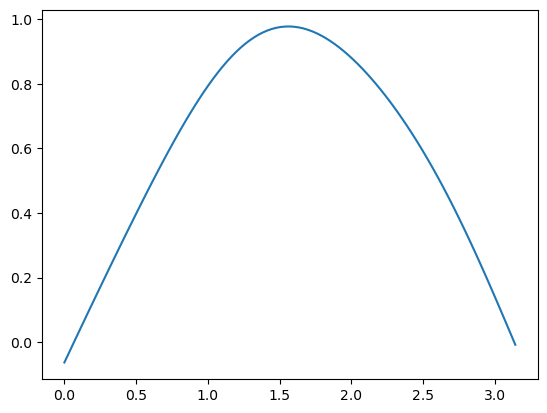

In [129]:
plt.plot(grid,means)
print(means.shape,stds.shape)
plt.fill_between(grid,means-stds,means+stds)